In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# 1. Import Data

In [2]:
data = pd.read_csv("/home/akanksha/Akanksha/Assignments/securly_Classification/dataset/train.csv")
data.shape

(159571, 8)

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
data.drop(columns=['id'], inplace=True)

## 2. Visualization

### 2.1. Check missing values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


In [6]:
data.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### 2.2. Number of comments for each toxic word

In [7]:
toxic_words = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

data[toxic_words].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

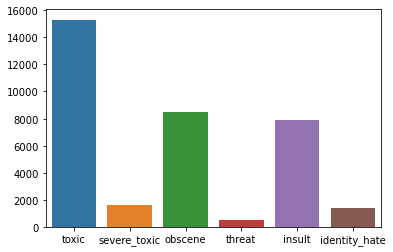

In [8]:
sb.barplot(toxic_words, data[toxic_words].sum().values)

### 2.3. Comments with multiple toxic words

In [9]:
sum_of_toxic_words_for_each_comment = data[toxic_words].sum(axis=1)
count_of_comments_for_each_toxic_word = sum_of_toxic_words_for_each_comment.value_counts()[1:]
count_of_comments_for_each_toxic_word

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64

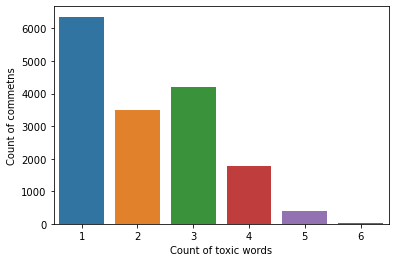

In [10]:
plt.xlabel("Count of toxic words")
plt.ylabel("Count of commetns")

sb.barplot(count_of_comments_for_each_toxic_word.index, count_of_comments_for_each_toxic_word.values)

### 2.4. Number of comments with and without toxic words

In [11]:
comments_with_toxic_words = sum_of_toxic_words_for_each_comment != 0
comments_without_toxic_words = sum_of_toxic_words_for_each_comment == 0
print('Number of comments with toxic words = {} \nNumber of commets without toxic words = {}'
      .format(comments_with_toxic_words.sum(), comments_without_toxic_words.sum()))

Number of comments with toxic words = 16225 
Number of commets without toxic words = 143346


### 2.5. Word Cloud Represntaion:

The following figure shows most common words in each category 

Toxic


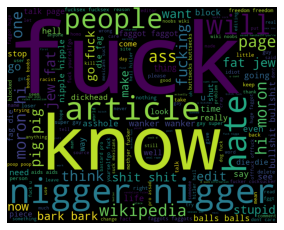

Severe_toxic


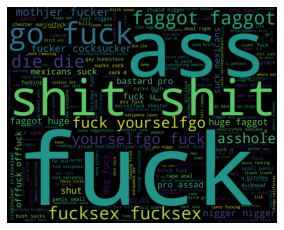

Obscene


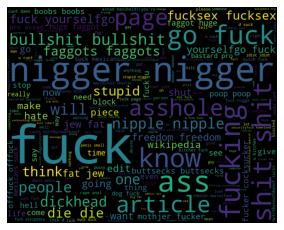

Threat


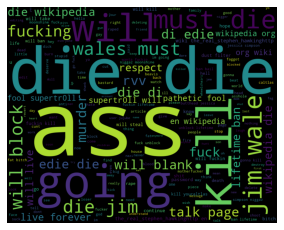

Insult


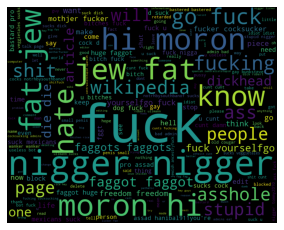

Identity_hate


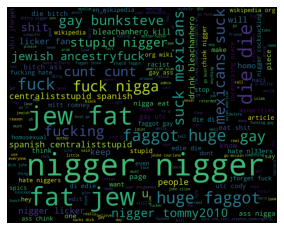

In [12]:
from wordcloud import WordCloud,STOPWORDS

def print_wordCloud(df):
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in df.comment_text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "
        
    wordcloud = WordCloud(width = 1000, height = 800, 
            background_color ='black', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (5, 3), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 
    
    
for i in toxic_words:
    print('\033[1m' + i.capitalize())
    print_wordCloud(data[data[i] == 1])

## 3. Data Preprocessing

In [13]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
import re

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


# Function to remove unwanted data and stop words. 
# Also it tokenizes the data to converts the words in it's stem form.
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
data['comment_text'] = data.comment_text.apply(lambda x: preprocess(x))

CPU times: user 25.4 s, sys: 30.1 ms, total: 25.4 s
Wall time: 25.4 s


## 4. Split data into Train and Test set

In [15]:
from sklearn.model_selection import train_test_split

feature = data['comment_text'] 
label = data.drop(columns=['comment_text'])

X_train, X_test, y_train, y_test = train_test_split(np.array(feature),
                                                    np.array(label),
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=42)


## 5. TF-IDF

It converts words to numbers. He we are using TDIDF as it assigns score to each words, and count vectoriser counts occurances of each word.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)
vectorizer.fit(X_test)

TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode')

In [17]:
X_train_vec = vectorizer.transform(X_train)

X_test_vec = vectorizer.transform(X_test)

In [18]:
y_train = pd.DataFrame(y_train, columns=toxic_words)
y_test = pd.DataFrame(y_test, columns=toxic_words)

## 6. Train the model

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
import sklearn

### Logistic Regression

In [30]:
%%time
Logistic_Regression_Pipeline = Pipeline([
                ('clf', OneVsRestClassifier(
                    sklearn.linear_model.LogisticRegression(solver='sag'), 
                    n_jobs=-1)),
            ])

for category in toxic_words:
    print("\033[1m" + "Accuracy for " + category.capitalize() +  "\033[0m")

    Logistic_Regression_Pipeline.fit(X_train_vec, y_train[category])
    
    test_prediction = Logistic_Regression_Pipeline.predict(X_test_vec)
    train_prediction = Logistic_Regression_Pipeline.predict(X_train_vec)
    print("Train Accuracy is {}".format(sklearn.metrics.accuracy_score(y_train[category], train_prediction)))
    print('Test accuracy is {} \n'.format(sklearn.metrics.accuracy_score(y_test[category], test_prediction)))

Accuracy for Toxic
Train Accuracy is 0.9596180359716738
Test accuracy is 0.9352655491148363 

Accuracy for Severe_toxic
Train Accuracy is 0.9909679137682522
Test accuracy is 0.9900360332132226 

Accuracy for Obscene
Train Accuracy is 0.978645735413925
Test accuracy is 0.9624314585618048 

Accuracy for Threat
Train Accuracy is 0.9970937519583881
Test accuracy is 0.9976500078333073 

Accuracy for Insult
Train Accuracy is 0.973130914332268
Test accuracy is 0.95770014099953 

Accuracy for Identity_hate
Train Accuracy is 0.9922917841699568
Test accuracy is 0.9908506971643428 

CPU times: user 821 ms, sys: 604 ms, total: 1.42 s
Wall time: 48.4 s


### SVM

In [37]:
%%time
SVM_Pipeline = Pipeline([
                ('clf', OneVsRestClassifier(
                    sklearn.svm.LinearSVC(C=0.1), 
                    n_jobs=-1)),
            ])

for category in toxic_words:
    print("\033[1m" + "Accuracy for " + category.capitalize() +  "\033[0m")
    
    SVM_Pipeline.fit(X_train_vec, y_train[category])
    
    test_prediction = SVM_Pipeline.predict(X_test_vec)
    train_prediction = SVM_Pipeline.predict(X_train_vec)
    print("Train Accuracy is {}".format(sklearn.metrics.accuracy_score(y_train[category], train_prediction)))
    print('Test accuracy is {} \n'.format(sklearn.metrics.accuracy_score(y_test[category], test_prediction)))
#     print(sklearn.metrics.hamming_loss(y_test[category], test_prediction)) 

Accuracy for Toxic
Train Accuracy is 0.9611142445321802
Test accuracy is 0.9367382108726304 

0.06326178912736957
Accuracy for Severe_toxic
Train Accuracy is 0.9910619164003259
Test accuracy is 0.9900046999843334 

0.009995300015666614
Accuracy for Obscene
Train Accuracy is 0.9805571222660902
Test accuracy is 0.9647814507284975 

0.035218549271502426
Accuracy for Threat
Train Accuracy is 0.9971250861690794
Test accuracy is 0.9976500078333073 

0.0023499921666927776
Accuracy for Insult
Train Accuracy is 0.9745017860500094
Test accuracy is 0.9585461381795394 

0.0414538618204606
Accuracy for Identity_hate
Train Accuracy is 0.9923074512753024
Test accuracy is 0.9909133636221212 

0.00908663637787874
CPU times: user 772 ms, sys: 547 ms, total: 1.32 s
Wall time: 7.21 s


In [ ]:
test_data = pd.read_csv("/home/akanksha/Akanksha/Assignments/securly_Classification/dataset/test.csv")
